In [2]:
import matplotlib.pyplot as plt
import numpy as np
import os

# from torchvision.datasets import MNIST
# from torchvision.transforms import ToTensor
import numpy as np

In [26]:
os.chdir("/home/vae")

## Dataloader

In [3]:
import os

import numpy as np
import torch
from torch.utils import data


class ImageDataLoader(data.Dataset):
    "My own Image Loader made to read .npy images"

    def __init__(self, directory, transform=None):

        self.directory = directory
        self.transform = transform
        self.file_names = [
            file
            for file in os.listdir(directory)
            if os.path.isfile(os.path.join(directory, file))
        ]

    def __len__(self):
        return len(self.file_names)

    def __getitem__(self, idx):

        img_path = os.path.join(self.directory, self.file_names[idx])
        image = np.load(img_path)
        image = image.astype(np.float32)

        if self.transform is not None:
            image = self.transform(image)

        image_labels = torch.zeros(image.shape[0])
        return image, image_labels


class ToTensorWithScaling:
    def __init__(self, min_val: float = 0.0, max_val: float = 1.0, eps: float = 1e-6):
        self.min_val = min_val
        self.max_val = max_val
        self.eps = eps

    def __call__(self, image: np.ndarray):
        image = torch.tensor(image, dtype=torch.float32)
        image = torch.permute(image, (2, 0, 1))

        # Get min and max values for every channel
        min_vals = image.amin(dim=(1, 2), keepdim=True)
        max_vals = image.amax(dim=(1, 2), keepdim=True)

        # [0, 1]
        image = (image - min_vals) / (max_vals - min_vals + self.eps)

        # [min_val, max_val]
        image = image * (self.max_val - self.min_val) + self.min_val

        # # rescale to 28 x 28
        # image = torch.nn.functional.interpolate(
        #     image.unsqueeze(0), (28, 28), mode="bilinear", align_corners=False
        # )
        # keep only 1 channel but keep the dimension
        # image = image.squeeze(0)[0].unsqueeze(0)

        return image

In [76]:
# import torchvision.transforms as transforms
from torch.utils.data import DataLoader

batch_size = 64

PATH_TEST_TYPICAL = "../dataset/test_typical"
PATH_TEST_NOVEL = "../dataset/test_novel/all"

RANDOM_SEED = 42

PATH_TRAIN = "../dataset/train_typical"
PATH_VALIDATION = "../dataset/validation_typical"

transform = ToTensorWithScaling(-1.0, 1.0)

# print(model_name, lr, epoch_number, device)

train_dataset = ImageDataLoader(PATH_TRAIN, transform=transform)
validation_dataset = ImageDataLoader(PATH_VALIDATION, transform=transform)

test_typical_dataset = ImageDataLoader(PATH_TEST_TYPICAL, transform=transform)
test_novel_dataset = ImageDataLoader(PATH_TEST_NOVEL, transform=transform)


train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(validation_dataset, batch_size=batch_size)

test_typical_loader = DataLoader(test_typical_dataset, batch_size=1)
test_novel_loader = DataLoader(test_novel_dataset, batch_size=1)

In [106]:
# verify that the data has no missing value
for i, (image, label) in enumerate(train_loader):
    if torch.isnan(image).any():
        print("Found missing value")
        break

# verify that data is in the correct range
for i, (image, label) in enumerate(train_loader):
    if torch.any(image < 0) or torch.any(image > 1.0):
        print("Found value outside of [0, 1]")
        break

## VAE Model definition

In [13]:
import pyro
import pyro.distributions as dist
import pyro.poutine as poutine
import torch
import torch.nn as nn
import torch.nn.functional as F

pyro.enable_validation(False)


class VEncoder(nn.Module):
    """Encoder for VAE."""

    def __init__(
        self,
        n_input_features: int,
        n_hidden_neurons: int,
        n_latent_features: int,
    ):
        """
        :param n_input_features: number of input features (28 x 28 = 784 for MNIST)
        :param n_hidden_neurons: number of neurons in hidden FC layer
        :param n_latent_features: size of the latent vector
        """
        super().__init__()
        self.input_to_hidden = nn.Linear(n_input_features, n_hidden_neurons)
        self.hidden_to_mu = nn.Linear(n_hidden_neurons, n_latent_features)
        self.hidden_to_sigma = nn.Linear(n_hidden_neurons, n_latent_features)

    def forward(self, x: torch.Tensor) -> tuple[torch.Tensor, torch.Tensor]:
        """Encode data to gaussian distribution params."""
        x = F.relu(self.input_to_hidden(x))
        z_loc = self.hidden_to_mu(x)
        z_scale = self.hidden_to_sigma(x).exp()
        return z_loc, z_scale


class VDecoder(nn.Module):
    """Decoder for VAE."""

    def __init__(
        self,
        n_latent_features: int,
        n_hidden_neurons: int,
        n_output_features: int,
    ):
        """
        :param n_latent_features: number of latent features (same as in Encoder)
        :param n_hidden_neurons: number of neurons in hidden FC layer
        :param n_output_features: size of the output vector (28 x 28 = 784 for MNIST)
        """
        super().__init__()
        self.latent_to_hidden = nn.Linear(n_latent_features, n_hidden_neurons)
        self.hidden_to_output = nn.Linear(n_hidden_neurons, n_output_features)

    def forward(self, z: torch.Tensor) -> torch.Tensor:
        """Decode latent vector to image."""
        r = F.relu(self.latent_to_hidden(z))
        r = torch.sigmoid(self.hidden_to_output(r))
        return r


class BaseAutoEncoder(nn.Module):
    """Base AutoEncoder module class."""

    def __init__(self, encoder: nn.Module, decoder: nn.Module, n_latent_features: int):
        """
        :param encoder: encoder network
        :param decoder: decoder network
        :param n_latent_features: number of latent features in the AE
        """
        super().__init__()
        self.n_latent_features: int = n_latent_features
        self.encoder: nn.Module = encoder
        self.decoder: nn.Module = decoder

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """Forward function for mapping input to output."""
        z = self.encoder_forward(x)
        return self.decoder_forward(z)

    def encoder_forward(self, x: torch.Tensor) -> torch.Tensor:
        """Function to perform forward pass through encoder network.

        takes: tensor of shape [batch_size x input_flattened_size] (flattened input)
        returns: tensor of shape [batch_size x latent_feature_size] (latent vector)
        """
        raise NotImplementedError()

    def decoder_forward(self, z: torch.Tensor) -> torch.Tensor:
        """Function to perform forward pass through decoder network.

        takes: tensor of shape [batch_size x latent_feature_size] (latent vector)
        returns: tensor of shape [batch_size x output_flattened_size] (flattened output)
        """
        raise NotImplementedError()


class VariationalAutoencoder(BaseAutoEncoder):
    """Variational Auto Encoder model."""

    def __init__(
        self,
        n_data_features: int,
        n_encoder_hidden_features: int,
        n_decoder_hidden_features: int,
        n_latent_features: int,
    ):
        """
        :param n_data_features: number of input and output features (28 x 28 = 784 for MNIST)
        :param n_encoder_hidden_features: number of neurons in encoder's hidden layer
        :param n_decoder_hidden_features: number of neurons in decoder's hidden layer
        :param n_latent_features: number of latent features
        """
        encoder = VEncoder(
            n_input_features=n_data_features,
            n_hidden_neurons=n_encoder_hidden_features,
            n_latent_features=n_latent_features,
        )
        decoder = VDecoder(
            n_latent_features=n_latent_features,
            n_hidden_neurons=n_decoder_hidden_features,
            n_output_features=n_data_features,
        )
        super().__init__(
            encoder=encoder, decoder=decoder, n_latent_features=n_latent_features
        )
        self.input_shape = None
        self.N = torch.distributions.Normal(0, 1)
        self.kl = 0

    def encoder_forward(self, x: torch.Tensor) -> torch.Tensor:
        """Function to perform forward pass through encoder network.
        takes: tensor of shape [batch_size x [image-size]] (input images batch)
        returns: tensor of shape [batch_size x latent_feature_size] (latent vector)
        """
        if self.input_shape is None:
            self.input_shape = x.shape[1:]
        x = x.view(x.shape[0], -1)
        z_loc, z_scale = self.encoder(x)
        z = z_loc + z_scale * self.N.sample(z_loc.shape).to(z_loc.device)
        return z

    def decoder_forward(self, z: torch.Tensor) -> torch.Tensor:
        """Function to perform forward pass through decoder network.
        takes: tensor of shape [batch_size x latent_feature_size] (latent vector)
        returns: tensor of shape [batch_size x [image-size]] (reconstructed images batch)
        """
        r = self.decoder(z)
        return r.view(-1, *self.input_shape)

    def model(self, x: torch.Tensor):
        """Pyro model for VAE; p(x|z)p(z)."""
        pyro.module("decoder", self.decoder)
        with pyro.plate("data", x.shape[0]):
            z_loc = torch.zeros((x.shape[0], self.n_latent_features)).to(x.device)
            z_scale = torch.ones((x.shape[0], self.n_latent_features)).to(x.device)
            z = pyro.sample("latent", dist.Normal(z_loc, z_scale).to_event(1))
            output = self.decoder.forward(z).view(-1, *self.input_shape)
            pyro.sample("obs", dist.Bernoulli(output).to_event(3), obs=x)

    def guide(self, x: torch.Tensor):
        """Pyro guide for VAE; q(z|x)"""
        pyro.module("encoder", self.encoder)
        with pyro.plate("data", x.shape[0]):
            z_loc, z_scale = self.encoder.forward(x.view(x.shape[0], -1))
            pyro.sample("latent", dist.Normal(z_loc, z_scale).to_event(1))


class BetaVariationalAutoencoder(VariationalAutoencoder):
    """beta-Variational Auto Encoder model."""

    def __init__(self, beta: float, **kwargs):
        """
        :param n_data_features: number of input and output features (28 x 28 = 784 for MNIST)
        :param n_encoder_hidden_features: number of neurons in encoder's hidden layer
        :param n_decoder_hidden_features: number of neurons in decoder's hidden layer
        :param n_latent_features: number of latent features
        :param beta: regularization coefficient
        """
        super().__init__(**kwargs)
        self.beta = beta

    def model(self, x: torch.Tensor):
        """Pyro model for beta-VAE; p(x|z)p(z)."""
        pyro.module("decoder", self.decoder)
        with pyro.plate("data", x.shape[0]):
            z_loc = torch.zeros((x.shape[0], self.n_latent_features)).to(x.device)
            z_scale = torch.ones((x.shape[0], self.n_latent_features)).to(x.device)
            z = pyro.sample("latent", dist.Normal(z_loc, z_scale).to_event(1))
            output = self.decoder.forward(z).view(-1, *self.input_shape)
            pyro.sample("obs", dist.Bernoulli(output).to_event(3), obs=x)

    def guide(self, x: torch.Tensor):
        """Pyro guide for beta-VAE; q(z|x)."""
        pyro.module("encoder", self.encoder)
        with pyro.plate("data", x.shape[0]):
            z_loc, z_scale = self.encoder.forward(x.view(x.shape[0], -1))
            with poutine.scale(scale=self.beta):
                pyro.sample("latent", dist.Normal(z_loc, z_scale).to_event(1))

## Train function:

In [89]:
from typing import Any, Dict, List, Optional, Tuple

import matplotlib.pyplot as plt
import torch
import torch.optim as optim
from sklearn.metrics import mean_squared_error
from torch.utils.data import DataLoader
from tqdm.auto import tqdm, trange
import numpy as np


def train_ae(
    model: BaseAutoEncoder,
    epochs: int,
    train_loader: DataLoader,
    val_loader: DataLoader,
    lr: float,
    loss_fn: callable,
    loss_fn_args: Optional[Tuple[Any]] = None,
) -> Tuple[Dict[str, List[float]], Dict[str, List[float]]]:
    """Train AE model and plot metrics.
    :param model: AE model
    :param epochs: number of epochs to train
    :param train_loader: train dataset loader
    :param val_loader: validation dataset loader
    :param lr: learning rate
    :param loss_fn: loss function to be applied
    :param loss_fn_kwargs: optional args to be passed to loss function
        instead of input and output
    :return: trained model
    """
    train_metrics = {
        "loss": [],
        "mse": [],
        "step": [],
    }
    val_metrics = {
        "loss": [],
        "mse": [],
        "step": [],
    }

    global_step = 0

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    optimizer = optim.Adam(model.parameters(), lr=lr)

    for epoch in trange(epochs, desc="epoch"):

        # training step
        model.train()
        pbar = tqdm(train_loader, desc="step", leave=False)
        for inputs, _ in pbar:  # we are not using labels for training
            inputs = inputs.to(device)

            optimizer.zero_grad()
            reconstructions = model(inputs)
            if loss_fn_args is None:
                args = (reconstructions, inputs)
            else:
                args = (*loss_fn_args, inputs)

            loss = loss_fn(*args)
            loss.backward()
            optimizer.step()

            if torch.isnan(reconstructions).any():
                print("rec nan found")
                print(reconstructions)
                if torch.isnan(reconstructions).all():
                    print("all values are nan")

            if torch.isnan(inputs).any():
                print("nan found")

            train_metrics["loss"].append(loss.item() / inputs.shape[0])
            train_metrics["mse"].append(
                mean_squared_error(
                    inputs.detach().cpu().view(inputs.shape[0], -1),
                    reconstructions.detach().cpu().view(reconstructions.shape[0], -1),
                )
            )
            train_metrics["step"].append(global_step)

            global_step += 1
            pbar.update(1)
        pbar.close()

        # validation step
        model.eval()
        val_loss = 0.0

        with torch.no_grad():
            total = 0
            for inputs, _ in val_loader:
                inputs = inputs.to(device)
                reconstructions = model(inputs)
                if loss_fn_args is None:
                    args = (reconstructions, inputs)
                else:
                    args = (*loss_fn_args, inputs)

                val_loss += loss_fn(*args) / inputs.shape[0]
                total += 1

        val_metrics["loss"].append(val_loss.item() / total)
        val_metrics["mse"].append(
            mean_squared_error(
                inputs.cpu().view(inputs.shape[0], -1),
                reconstructions.cpu().view(reconstructions.shape[0], -1),
            )
        )
        val_metrics["step"].append(global_step)

        print(
            f"Epoch: {epoch}, ",
            f"Train loss: {train_metrics['loss'][-1]}",
            f"Val loss: {val_metrics['loss'][-1]}",
            f"Train MSE: {train_metrics['mse'][-1]}",
        )

    plot_metrics(train_metrics, val_metrics)
    return model, train_metrics, val_metrics


def plot_metrics(
    train_metrics: Dict[str, List[float]], val_metrics: Dict[str, List[float]]
):
    """Plot train and val metrics after training."""
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(5, 8), sharex=True)

    ax1.plot(train_metrics["step"], train_metrics["loss"], label="train loss")
    ax1.plot(val_metrics["step"], val_metrics["loss"], label="val loss")
    ax2.plot(train_metrics["step"], train_metrics["mse"], label="train mse")
    ax2.plot(val_metrics["step"], val_metrics["mse"], label="val mse")
    ax1.set_xlabel("Training step")
    ax1.set_ylabel("Loss")
    ax2.set_ylabel("MSE")
    ax1.set_title("Learning curves")
    ax1.grid()
    ax1.legend()
    ax2.grid()
    ax2.legend()
    plt.show()

## Run Train


n_latent_features=256, n_hidden_features=1024, lr=1e-06


epoch:   2%|▏         | 1/50 [00:08<06:35,  8.08s/it]

Epoch: 0,  Train loss: 16960.647727272728 Val loss: 16878.875 Train MSE: 0.3266894519329071


epoch:   4%|▍         | 2/50 [00:16<06:28,  8.10s/it]

Epoch: 1,  Train loss: 16670.700284090908 Val loss: 16454.83806818182 Train MSE: 0.3018234968185425


epoch:   6%|▌         | 3/50 [00:24<06:20,  8.10s/it]

Epoch: 2,  Train loss: 16226.630681818182 Val loss: 15689.198863636364 Train MSE: 0.322432279586792


epoch:   8%|▊         | 4/50 [00:32<06:14,  8.14s/it]

Epoch: 3,  Train loss: 14875.178977272728 Val loss: 14461.072443181818 Train MSE: 0.3075767457485199


epoch:  10%|█         | 5/50 [00:40<06:05,  8.13s/it]

Epoch: 4,  Train loss: 15522.525568181818 Val loss: 12795.985795454546 Train MSE: 0.26885154843330383


epoch:  12%|█▏        | 6/50 [00:48<05:57,  8.13s/it]

Epoch: 5,  Train loss: 11734.061079545454 Val loss: 10786.09090909091 Train MSE: 0.28104695677757263


epoch:  14%|█▍        | 7/50 [00:56<05:49,  8.13s/it]

Epoch: 6,  Train loss: 12860.936079545454 Val loss: 8551.571022727272 Train MSE: 0.2345094084739685


epoch:  16%|█▌        | 8/50 [01:04<05:40,  8.11s/it]

Epoch: 7,  Train loss: 9998.15625 Val loss: 6213.905539772727 Train MSE: 0.2453540563583374


epoch:  18%|█▊        | 9/50 [01:12<05:31,  8.09s/it]

Epoch: 8,  Train loss: 8996.724431818182 Val loss: 3735.1548295454545 Train MSE: 0.2443341761827469


epoch:  20%|██        | 10/50 [01:21<05:23,  8.09s/it]

Epoch: 9,  Train loss: 8338.029829545454 Val loss: 1063.5496271306818 Train MSE: 0.23429006338119507


epoch:  22%|██▏       | 11/50 [01:28<05:13,  8.03s/it]

Epoch: 10,  Train loss: 6583.654119318182 Val loss: -1764.987215909091 Train MSE: 0.2083491086959839


epoch:  24%|██▍       | 12/50 [01:37<05:05,  8.04s/it]

Epoch: 11,  Train loss: -2202.2702414772725 Val loss: -4159.456676136364 Train MSE: 0.1735491305589676


epoch:  26%|██▌       | 13/50 [01:45<04:59,  8.09s/it]

Epoch: 12,  Train loss: -3208.9985795454545 Val loss: -5917.994673295455 Train MSE: 0.16574084758758545


epoch:  28%|██▊       | 14/50 [01:53<04:50,  8.08s/it]

Epoch: 13,  Train loss: 9769.496448863636 Val loss: -7158.233664772727 Train MSE: 0.18660669028759003


epoch:  30%|███       | 15/50 [02:01<04:43,  8.09s/it]

Epoch: 14,  Train loss: -6624.692471590909 Val loss: -8086.21875 Train MSE: 0.19794054329395294


epoch:  32%|███▏      | 16/50 [02:09<04:36,  8.12s/it]

Epoch: 15,  Train loss: -11707.764204545454 Val loss: -8814.761363636364 Train MSE: 0.19091589748859406


epoch:  34%|███▍      | 17/50 [02:17<04:29,  8.16s/it]

Epoch: 16,  Train loss: -5647.517045454545 Val loss: -9445.068892045454 Train MSE: 0.17405875027179718


epoch:  36%|███▌      | 18/50 [02:25<04:20,  8.16s/it]

Epoch: 17,  Train loss: -5742.426491477273 Val loss: -10024.15127840909 Train MSE: 0.18624329566955566


epoch:  38%|███▊      | 19/50 [02:34<04:13,  8.16s/it]

Epoch: 18,  Train loss: -1343.9423828125 Val loss: -10564.551136363636 Train MSE: 0.18406260013580322


epoch:  40%|████      | 20/50 [02:42<04:04,  8.16s/it]

Epoch: 19,  Train loss: 2126.318181818182 Val loss: -11118.33877840909 Train MSE: 0.19499003887176514


epoch:  42%|████▏     | 21/50 [02:50<03:56,  8.15s/it]

Epoch: 20,  Train loss: 1936.109375 Val loss: -11687.7734375 Train MSE: 0.17992188036441803


epoch:  44%|████▍     | 22/50 [02:58<03:46,  8.10s/it]

Epoch: 21,  Train loss: -961.6853693181819 Val loss: -12285.926136363636 Train MSE: 0.16153663396835327


epoch:  46%|████▌     | 23/50 [03:06<03:39,  8.14s/it]

Epoch: 22,  Train loss: 6397.477982954545 Val loss: -12907.977272727272 Train MSE: 0.20711307227611542


epoch:  48%|████▊     | 24/50 [03:14<03:31,  8.13s/it]

Epoch: 23,  Train loss: 11967.56534090909 Val loss: -13593.541193181818 Train MSE: 0.16845951974391937


epoch:  50%|█████     | 25/50 [03:22<03:23,  8.13s/it]

Epoch: 24,  Train loss: 4282.713423295455 Val loss: -14315.801136363636 Train MSE: 0.1575748771429062


epoch:  52%|█████▏    | 26/50 [03:31<03:15,  8.16s/it]

Epoch: 25,  Train loss: -9274.939630681818 Val loss: -15108.426136363636 Train MSE: 0.1721539944410324


epoch:  54%|█████▍    | 27/50 [03:39<03:08,  8.18s/it]

Epoch: 26,  Train loss: -8691.15340909091 Val loss: -15902.163352272728 Train MSE: 0.16882501542568207


epoch:  56%|█████▌    | 28/50 [03:47<03:00,  8.23s/it]

Epoch: 27,  Train loss: 2979.4453125 Val loss: -16682.153409090908 Train MSE: 0.1905420869588852


epoch:  58%|█████▊    | 29/50 [03:55<02:52,  8.23s/it]

Epoch: 28,  Train loss: 7540.654119318182 Val loss: -17400.627840909092 Train MSE: 0.1743621826171875


epoch:  60%|██████    | 30/50 [04:04<02:45,  8.26s/it]

Epoch: 29,  Train loss: 364.66177645596593 Val loss: -18078.852272727272 Train MSE: 0.16143308579921722


epoch:  62%|██████▏   | 31/50 [04:12<02:37,  8.28s/it]

Epoch: 30,  Train loss: -5944.092684659091 Val loss: -18698.154829545456 Train MSE: 0.1592448204755783


epoch:  64%|██████▍   | 32/50 [04:20<02:27,  8.21s/it]

Epoch: 31,  Train loss: 300.79203657670456 Val loss: -19276.15056818182 Train MSE: 0.17086045444011688


epoch:  66%|██████▌   | 33/50 [04:28<02:18,  8.17s/it]

Epoch: 32,  Train loss: -10045.626420454546 Val loss: -19790.819602272728 Train MSE: 0.14440377056598663


epoch:  68%|██████▊   | 34/50 [04:36<02:10,  8.13s/it]

Epoch: 33,  Train loss: -11606.819602272728 Val loss: -20286.335227272728 Train MSE: 0.162251815199852


epoch:  70%|███████   | 35/50 [04:44<02:02,  8.13s/it]

Epoch: 34,  Train loss: -22029.69744318182 Val loss: -20754.464488636364 Train MSE: 0.1881314516067505


epoch:  72%|███████▏  | 36/50 [04:52<01:53,  8.10s/it]

Epoch: 35,  Train loss: -10275.410511363636 Val loss: -21199.904829545456 Train MSE: 0.15748004615306854


epoch:  74%|███████▍  | 37/50 [05:01<01:45,  8.10s/it]

Epoch: 36,  Train loss: -9088.845170454546 Val loss: -21616.63494318182 Train MSE: 0.17006178200244904


epoch:  76%|███████▌  | 38/50 [05:08<01:36,  8.04s/it]

Epoch: 37,  Train loss: -11999.286931818182 Val loss: -22036.647727272728 Train MSE: 0.17108191549777985


epoch:  78%|███████▊  | 39/50 [05:16<01:28,  8.04s/it]

Epoch: 38,  Train loss: -11393.910511363636 Val loss: -22423.207386363636 Train MSE: 0.18230466544628143


epoch:  80%|████████  | 40/50 [05:24<01:20,  8.03s/it]

Epoch: 39,  Train loss: -4485.22265625 Val loss: -22830.13068181818 Train MSE: 0.13081981241703033


epoch:  82%|████████▏ | 41/50 [05:32<01:12,  8.03s/it]

Epoch: 40,  Train loss: -15206.607954545454 Val loss: -23212.519886363636 Train MSE: 0.1697683185338974


epoch:  84%|████████▍ | 42/50 [05:40<01:04,  8.01s/it]

Epoch: 41,  Train loss: 3397.3852982954545 Val loss: -23585.071022727272 Train MSE: 0.13599522411823273


epoch:  86%|████████▌ | 43/50 [05:48<00:55,  7.94s/it]

Epoch: 42,  Train loss: -17652.571022727272 Val loss: -23946.159090909092 Train MSE: 0.14522118866443634


epoch:  88%|████████▊ | 44/50 [05:56<00:47,  7.97s/it]

Epoch: 43,  Train loss: -318.3350941051136 Val loss: -24332.028409090908 Train MSE: 0.13569553196430206


epoch:  90%|█████████ | 45/50 [06:04<00:39,  7.95s/it]

Epoch: 44,  Train loss: -13905.900568181818 Val loss: -24675.394886363636 Train MSE: 0.1754780262708664


epoch:  92%|█████████▏| 46/50 [06:12<00:31,  7.98s/it]

Epoch: 45,  Train loss: -7289.111505681818 Val loss: -25030.93181818182 Train MSE: 0.171434685587883


epoch:  94%|█████████▍| 47/50 [06:20<00:23,  7.98s/it]

Epoch: 46,  Train loss: -5514.509232954545 Val loss: -25369.44318181818 Train MSE: 0.16505305469036102


epoch:  96%|█████████▌| 48/50 [06:28<00:15,  7.99s/it]

Epoch: 47,  Train loss: -7961.696732954545 Val loss: -25736.048295454544 Train MSE: 0.1739569753408432


epoch:  98%|█████████▊| 49/50 [06:36<00:07,  7.99s/it]

Epoch: 48,  Train loss: -8360.630681818182 Val loss: -26035.715909090908 Train MSE: 0.15244747698307037


epoch: 100%|██████████| 50/50 [06:44<00:00,  8.10s/it]

Epoch: 49,  Train loss: -18921.180397727272 Val loss: -26366.670454545456 Train MSE: 0.1816815733909607


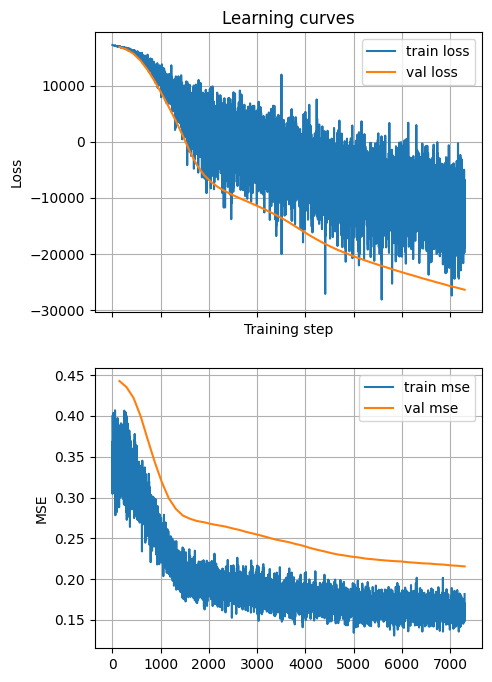

In [99]:
# from train_vae_mnist import train_ae as train_ae

pyro.enable_validation(False)

epochs = 50

n_hidden_features = 1024
n_latent_features = 256
lr = 1e-6


results = []

vae_model = VariationalAutoencoder(
    n_data_features=64 * 64 * 6,
    n_encoder_hidden_features=n_hidden_features,
    n_decoder_hidden_features=n_hidden_features,
    n_latent_features=n_latent_features,  # how many features will be used to represent input
)

loss_fn = pyro.infer.Trace_ELBO().differentiable_loss
loss_fn_args = (vae_model.model, vae_model.guide)
print(f"\n{n_latent_features=}, {n_hidden_features=}, {lr=}")

res = train_ae(
    vae_model,
    epochs=epochs,
    train_loader=train_loader,
    val_loader=val_loader,
    lr=lr,
    loss_fn=loss_fn,
    loss_fn_args=loss_fn_args,
    # clip_value=500000,
)

epoch:   1%|          | 1/100 [00:08<13:14,  8.02s/it]

Epoch: 0,  Train loss: -31587.267045454544 Val loss: -40395.786931818184 Train MSE: 0.153575599193573


epoch:   2%|▏         | 2/100 [00:16<13:05,  8.02s/it]

Epoch: 1,  Train loss: -24081.40056818182 Val loss: -40412.63636363636 Train MSE: 0.16139663755893707


epoch:   3%|▎         | 3/100 [00:23<12:54,  7.98s/it]

Epoch: 2,  Train loss: -22835.727272727272 Val loss: -40427.16477272727 Train MSE: 0.1325036585330963


epoch:   4%|▍         | 4/100 [00:31<12:37,  7.89s/it]

Epoch: 3,  Train loss: -16692.092329545456 Val loss: -40430.04261363636 Train MSE: 0.12126997113227844


epoch:   5%|▌         | 5/100 [00:39<12:29,  7.89s/it]

Epoch: 4,  Train loss: -19571.514204545456 Val loss: -40430.639204545456 Train MSE: 0.13219155371189117


epoch:   6%|▌         | 6/100 [00:47<12:24,  7.92s/it]

Epoch: 5,  Train loss: -29041.017045454544 Val loss: -40425.67613636364 Train MSE: 0.15789584815502167


epoch:   7%|▋         | 7/100 [00:55<12:17,  7.93s/it]

Epoch: 6,  Train loss: -11015.500710227272 Val loss: -40422.09090909091 Train MSE: 0.11928699165582657


epoch:   8%|▊         | 8/100 [01:03<12:08,  7.92s/it]

Epoch: 7,  Train loss: -27449.326704545456 Val loss: -40422.09659090909 Train MSE: 0.1339927315711975


epoch:   9%|▉         | 9/100 [01:11<12:06,  7.99s/it]

Epoch: 8,  Train loss: -19928.319602272728 Val loss: -40433.33522727273 Train MSE: 0.1251094490289688


epoch:  10%|█         | 10/100 [01:19<11:56,  7.96s/it]

Epoch: 9,  Train loss: -16391.332386363636 Val loss: -40440.55965909091 Train MSE: 0.12491051107645035


epoch:  11%|█         | 11/100 [01:27<11:48,  7.96s/it]

Epoch: 10,  Train loss: -21573.357954545456 Val loss: -40449.74715909091 Train MSE: 0.1409478634595871


epoch:  12%|█▏        | 12/100 [01:35<11:40,  7.96s/it]

Epoch: 11,  Train loss: -19352.816761363636 Val loss: -40451.485795454544 Train MSE: 0.12182691693305969


epoch:  13%|█▎        | 13/100 [01:43<11:31,  7.95s/it]

Epoch: 12,  Train loss: -16046.079545454546 Val loss: -40450.41477272727 Train MSE: 0.1177116110920906


epoch:  14%|█▍        | 14/100 [01:51<11:23,  7.95s/it]

Epoch: 13,  Train loss: -11912.280539772728 Val loss: -40461.1875 Train MSE: 0.1288144737482071


epoch:  15%|█▌        | 15/100 [01:59<11:15,  7.95s/it]

Epoch: 14,  Train loss: -28655.71306818182 Val loss: -40465.732954545456 Train MSE: 0.14584189653396606


epoch:  16%|█▌        | 16/100 [02:07<11:05,  7.92s/it]

Epoch: 15,  Train loss: -29866.61931818182 Val loss: -40463.017045454544 Train MSE: 0.15321095287799835


epoch:  17%|█▋        | 17/100 [02:14<10:57,  7.92s/it]

Epoch: 16,  Train loss: -25910.528409090908 Val loss: -40461.943181818184 Train MSE: 0.13868173956871033


epoch:  18%|█▊        | 18/100 [02:22<10:47,  7.89s/it]

Epoch: 17,  Train loss: -14713.005681818182 Val loss: -40466.369318181816 Train MSE: 0.13386715948581696


epoch:  19%|█▉        | 19/100 [02:30<10:40,  7.91s/it]

Epoch: 18,  Train loss: -26316.80681818182 Val loss: -40470.60511363636 Train MSE: 0.14086434245109558


epoch:  20%|██        | 20/100 [02:38<10:32,  7.91s/it]

Epoch: 19,  Train loss: -20622.676136363636 Val loss: -40468.1875 Train MSE: 0.1160426214337349


epoch:  21%|██        | 21/100 [02:46<10:23,  7.89s/it]

Epoch: 20,  Train loss: -12891.897727272728 Val loss: -40488.42897727273 Train MSE: 0.1252559870481491


epoch:  22%|██▏       | 22/100 [02:54<10:16,  7.90s/it]

Epoch: 21,  Train loss: -34259.82386363636 Val loss: -40477.15909090909 Train MSE: 0.15838722884655


epoch:  23%|██▎       | 23/100 [03:02<10:09,  7.91s/it]

Epoch: 22,  Train loss: -21747.99431818182 Val loss: -40488.84090909091 Train MSE: 0.1423349231481552


epoch:  24%|██▍       | 24/100 [03:10<09:59,  7.89s/it]

Epoch: 23,  Train loss: -10351.165482954546 Val loss: -40482.454545454544 Train MSE: 0.12207528203725815


epoch:  25%|██▌       | 25/100 [03:18<09:52,  7.90s/it]

Epoch: 24,  Train loss: -19539.99005681818 Val loss: -40493.29261363636 Train MSE: 0.13124872744083405


epoch:  26%|██▌       | 26/100 [03:26<09:45,  7.91s/it]

Epoch: 25,  Train loss: -25403.309659090908 Val loss: -40499.25284090909 Train MSE: 0.11921605467796326


epoch:  27%|██▋       | 27/100 [03:33<09:37,  7.91s/it]

Epoch: 26,  Train loss: -36177.775568181816 Val loss: -40484.713068181816 Train MSE: 0.15512478351593018


epoch:  28%|██▊       | 28/100 [03:41<09:27,  7.88s/it]

Epoch: 27,  Train loss: -23779.745738636364 Val loss: -40490.00852272727 Train MSE: 0.13600170612335205


epoch:  29%|██▉       | 29/100 [03:49<09:19,  7.88s/it]

Epoch: 28,  Train loss: -20534.684659090908 Val loss: -40499.66477272727 Train MSE: 0.12902683019638062


epoch:  30%|███       | 30/100 [03:57<09:09,  7.85s/it]

Epoch: 29,  Train loss: -40910.73863636364 Val loss: -40508.02272727273 Train MSE: 0.14265607297420502


epoch:  31%|███       | 31/100 [04:05<09:03,  7.88s/it]

Epoch: 30,  Train loss: -31515.491477272728 Val loss: -40505.40625 Train MSE: 0.13452845811843872


epoch:  32%|███▏      | 32/100 [04:13<08:55,  7.87s/it]

Epoch: 31,  Train loss: -19460.366477272728 Val loss: -40507.08522727273 Train MSE: 0.13167737424373627


epoch:  33%|███▎      | 33/100 [04:21<08:47,  7.87s/it]

Epoch: 32,  Train loss: -22344.47443181818 Val loss: -40502.52272727273 Train MSE: 0.12697507441043854


epoch:  34%|███▍      | 34/100 [04:28<08:38,  7.86s/it]

Epoch: 33,  Train loss: -23173.845170454544 Val loss: -40521.47727272727 Train MSE: 0.14208915829658508


epoch:  35%|███▌      | 35/100 [04:36<08:31,  7.87s/it]

Epoch: 34,  Train loss: -32481.028409090908 Val loss: -40519.32102272727 Train MSE: 0.14933185279369354


epoch:  36%|███▌      | 36/100 [04:44<08:27,  7.93s/it]

Epoch: 35,  Train loss: -14354.93465909091 Val loss: -40526.161931818184 Train MSE: 0.12465125322341919


epoch:  37%|███▋      | 37/100 [04:52<08:17,  7.90s/it]

Epoch: 36,  Train loss: -31647.301136363636 Val loss: -40534.41761363636 Train MSE: 0.14577510952949524


epoch:  38%|███▊      | 38/100 [05:00<08:07,  7.86s/it]

Epoch: 37,  Train loss: -23282.465909090908 Val loss: -40521.65625 Train MSE: 0.1476479172706604


epoch:  39%|███▉      | 39/100 [05:08<07:59,  7.86s/it]

Epoch: 38,  Train loss: -14562.522727272728 Val loss: -40537.170454545456 Train MSE: 0.13385392725467682


epoch:  40%|████      | 40/100 [05:16<07:51,  7.86s/it]

Epoch: 39,  Train loss: -16644.512784090908 Val loss: -40535.64772727273 Train MSE: 0.11962667852640152


epoch:  41%|████      | 41/100 [05:24<07:44,  7.87s/it]

Epoch: 40,  Train loss: -26106.798295454544 Val loss: -40538.318181818184 Train MSE: 0.13229434192180634


epoch:  42%|████▏     | 42/100 [05:31<07:35,  7.86s/it]

Epoch: 41,  Train loss: -37222.23863636364 Val loss: -40541.724431818184 Train MSE: 0.15974114835262299


epoch:  43%|████▎     | 43/100 [05:39<07:28,  7.86s/it]

Epoch: 42,  Train loss: -41179.02272727273 Val loss: -40543.818181818184 Train MSE: 0.14135511219501495


epoch:  44%|████▍     | 44/100 [05:47<07:20,  7.87s/it]

Epoch: 43,  Train loss: -11674.347301136364 Val loss: -40547.35511363636 Train MSE: 0.10809046775102615


epoch:  45%|████▌     | 45/100 [05:55<07:13,  7.88s/it]

Epoch: 44,  Train loss: -31228.210227272728 Val loss: -40549.36647727273 Train MSE: 0.14438682794570923


epoch:  46%|████▌     | 46/100 [06:03<07:05,  7.88s/it]

Epoch: 45,  Train loss: -26637.460227272728 Val loss: -40554.826704545456 Train MSE: 0.13628998398780823


epoch:  47%|████▋     | 47/100 [06:11<06:58,  7.89s/it]

Epoch: 46,  Train loss: -30392.863636363636 Val loss: -40570.47727272727 Train MSE: 0.1363789290189743


epoch:  48%|████▊     | 48/100 [06:19<06:49,  7.87s/it]

Epoch: 47,  Train loss: -27402.863636363636 Val loss: -40555.60511363636 Train MSE: 0.1371568888425827


epoch:  49%|████▉     | 49/100 [06:27<06:42,  7.90s/it]

Epoch: 48,  Train loss: -20964.329545454544 Val loss: -40574.83522727273 Train MSE: 0.12403210252523422


epoch:  50%|█████     | 50/100 [06:35<06:35,  7.90s/it]

Epoch: 49,  Train loss: -14836.051136363636 Val loss: -40572.849431818184 Train MSE: 0.11269444972276688


epoch:  51%|█████     | 51/100 [06:43<06:27,  7.90s/it]

Epoch: 50,  Train loss: -38589.826704545456 Val loss: -40573.943181818184 Train MSE: 0.1484689861536026


epoch:  52%|█████▏    | 52/100 [06:50<06:17,  7.86s/it]

Epoch: 51,  Train loss: -11293.289772727272 Val loss: -40581.21875 Train MSE: 0.1218639612197876


epoch:  53%|█████▎    | 53/100 [06:58<06:09,  7.87s/it]

Epoch: 52,  Train loss: -10326.916193181818 Val loss: -40575.360795454544 Train MSE: 0.12095300108194351


epoch:  54%|█████▍    | 54/100 [07:06<06:01,  7.86s/it]

Epoch: 53,  Train loss: -15502.602272727272 Val loss: -40585.693181818184 Train MSE: 0.11619173735380173


epoch:  55%|█████▌    | 55/100 [07:14<05:51,  7.82s/it]

Epoch: 54,  Train loss: -17680.703125 Val loss: -40585.911931818184 Train MSE: 0.11814496666193008


epoch:  56%|█████▌    | 56/100 [07:22<05:45,  7.86s/it]

Epoch: 55,  Train loss: -12093.475852272728 Val loss: -40591.09090909091 Train MSE: 0.1080300509929657


epoch:  57%|█████▋    | 57/100 [07:29<05:37,  7.84s/it]

Epoch: 56,  Train loss: -18460.262784090908 Val loss: -40587.71875 Train MSE: 0.12448921799659729


epoch:  58%|█████▊    | 58/100 [07:37<05:30,  7.87s/it]

Epoch: 57,  Train loss: -18897.714488636364 Val loss: -40586.01136363636 Train MSE: 0.13063257932662964


epoch:  59%|█████▉    | 59/100 [07:45<05:22,  7.87s/it]

Epoch: 58,  Train loss: -26284.892045454544 Val loss: -40598.463068181816 Train MSE: 0.12911637127399445


epoch:  60%|██████    | 60/100 [07:53<05:13,  7.85s/it]

Epoch: 59,  Train loss: -38911.568181818184 Val loss: -40593.76136363636 Train MSE: 0.15608693659305573


epoch:  61%|██████    | 61/100 [08:01<05:06,  7.85s/it]

Epoch: 60,  Train loss: -9071.649857954546 Val loss: -40605.13636363636 Train MSE: 0.11280176788568497


epoch:  62%|██████▏   | 62/100 [08:09<04:57,  7.84s/it]

Epoch: 61,  Train loss: -40477.244318181816 Val loss: -40596.46022727273 Train MSE: 0.16035497188568115


epoch:  63%|██████▎   | 63/100 [08:17<04:52,  7.91s/it]

Epoch: 62,  Train loss: -33124.59659090909 Val loss: -40603.55965909091 Train MSE: 0.15466149151325226


epoch:  64%|██████▍   | 64/100 [08:25<04:44,  7.90s/it]

Epoch: 63,  Train loss: -22333.673295454544 Val loss: -40602.642045454544 Train MSE: 0.14593161642551422


epoch:  65%|██████▌   | 65/100 [08:33<04:35,  7.88s/it]

Epoch: 64,  Train loss: -21184.214488636364 Val loss: -40619.55113636364 Train MSE: 0.12284082174301147


epoch:  66%|██████▌   | 66/100 [08:40<04:27,  7.88s/it]

Epoch: 65,  Train loss: -13422.54971590909 Val loss: -40625.46875 Train MSE: 0.1112014427781105


epoch:  67%|██████▋   | 67/100 [08:48<04:19,  7.87s/it]

Epoch: 66,  Train loss: -28649.136363636364 Val loss: -40624.60227272727 Train MSE: 0.13801072537899017


epoch:  68%|██████▊   | 68/100 [08:56<04:12,  7.89s/it]

Epoch: 67,  Train loss: -24622.769886363636 Val loss: -40618.607954545456 Train MSE: 0.14119203388690948


epoch:  69%|██████▉   | 69/100 [09:04<04:04,  7.89s/it]

Epoch: 68,  Train loss: -21489.41193181818 Val loss: -40621.05397727273 Train MSE: 0.1199779137969017


epoch:  70%|███████   | 70/100 [09:12<03:55,  7.86s/it]

Epoch: 69,  Train loss: -14679.894886363636 Val loss: -40634.85511363636 Train MSE: 0.11206897348165512


epoch:  71%|███████   | 71/100 [09:20<03:48,  7.87s/it]

Epoch: 70,  Train loss: -7688.784090909091 Val loss: -40644.661931818184 Train MSE: 0.11342215538024902


epoch:  72%|███████▏  | 72/100 [09:28<03:39,  7.84s/it]

Epoch: 71,  Train loss: -13938.00284090909 Val loss: -40627.110795454544 Train MSE: 0.11615533381700516


epoch:  73%|███████▎  | 73/100 [09:35<03:31,  7.83s/it]

Epoch: 72,  Train loss: -23888.90056818182 Val loss: -40641.68465909091 Train MSE: 0.13646619021892548


epoch:  74%|███████▍  | 74/100 [09:43<03:23,  7.84s/it]

Epoch: 73,  Train loss: -26594.258522727272 Val loss: -40629.72159090909 Train MSE: 0.13626061379909515


epoch:  75%|███████▌  | 75/100 [09:51<03:15,  7.83s/it]

Epoch: 74,  Train loss: -21777.8125 Val loss: -40651.13352272727 Train MSE: 0.12813632190227509


epoch:  76%|███████▌  | 76/100 [09:59<03:07,  7.80s/it]

Epoch: 75,  Train loss: -17177.91193181818 Val loss: -40649.795454545456 Train MSE: 0.12309645861387253


epoch:  77%|███████▋  | 77/100 [10:07<02:59,  7.81s/it]

Epoch: 76,  Train loss: -15791.589488636364 Val loss: -40659.50284090909 Train MSE: 0.11261927336454391


epoch:  78%|███████▊  | 78/100 [10:15<02:52,  7.85s/it]

Epoch: 77,  Train loss: -19200.528409090908 Val loss: -40657.12784090909 Train MSE: 0.1366572380065918


epoch:  79%|███████▉  | 79/100 [10:22<02:45,  7.87s/it]

Epoch: 78,  Train loss: -32154.372159090908 Val loss: -40669.51136363636 Train MSE: 0.1481109857559204


epoch:  80%|████████  | 80/100 [10:30<02:38,  7.91s/it]

Epoch: 79,  Train loss: -47709.89772727273 Val loss: -40644.46875 Train MSE: 0.16849152743816376


epoch:  81%|████████  | 81/100 [10:38<02:30,  7.93s/it]

Epoch: 80,  Train loss: -28210.928977272728 Val loss: -40662.22727272727 Train MSE: 0.1426120400428772


epoch:  82%|████████▏ | 82/100 [10:47<02:23,  8.00s/it]

Epoch: 81,  Train loss: -22395.640625 Val loss: -40666.03977272727 Train MSE: 0.12474456429481506


epoch:  83%|████████▎ | 83/100 [10:55<02:16,  8.02s/it]

Epoch: 82,  Train loss: -43346.732954545456 Val loss: -40668.04261363636 Train MSE: 0.1683599352836609


epoch:  84%|████████▍ | 84/100 [11:03<02:08,  8.04s/it]

Epoch: 83,  Train loss: -32384.860795454544 Val loss: -40677.099431818184 Train MSE: 0.14497585594654083


epoch:  85%|████████▌ | 85/100 [11:11<02:00,  8.04s/it]

Epoch: 84,  Train loss: -15992.828125 Val loss: -40678.076704545456 Train MSE: 0.12708117067813873


epoch:  86%|████████▌ | 86/100 [11:19<01:52,  8.04s/it]

Epoch: 85,  Train loss: -26745.451704545456 Val loss: -40690.19034090909 Train MSE: 0.13232648372650146


epoch:  87%|████████▋ | 87/100 [11:27<01:44,  8.03s/it]

Epoch: 86,  Train loss: -23949.440340909092 Val loss: -40682.64488636364 Train MSE: 0.12289849668741226


epoch:  88%|████████▊ | 88/100 [11:35<01:36,  8.02s/it]

Epoch: 87,  Train loss: -22359.308238636364 Val loss: -40691.494318181816 Train MSE: 0.1260363608598709


epoch:  89%|████████▉ | 89/100 [11:43<01:28,  8.02s/it]

Epoch: 88,  Train loss: -17351.710227272728 Val loss: -40685.95738636364 Train MSE: 0.13247567415237427


epoch:  90%|█████████ | 90/100 [11:51<01:20,  8.09s/it]

Epoch: 89,  Train loss: -28452.36931818182 Val loss: -40698.713068181816 Train MSE: 0.1307995766401291


epoch:  91%|█████████ | 91/100 [11:59<01:12,  8.08s/it]

Epoch: 90,  Train loss: -20060.74431818182 Val loss: -40693.57102272727 Train MSE: 0.12215307354927063


epoch:  92%|█████████▏| 92/100 [12:07<01:04,  8.03s/it]

Epoch: 91,  Train loss: -29843.27556818182 Val loss: -40685.048295454544 Train MSE: 0.1365640014410019


epoch:  93%|█████████▎| 93/100 [12:15<00:56,  8.04s/it]

Epoch: 92,  Train loss: -20145.428977272728 Val loss: -40711.107954545456 Train MSE: 0.12239236384630203


epoch:  94%|█████████▍| 94/100 [12:23<00:48,  8.04s/it]

Epoch: 93,  Train loss: -12827.563920454546 Val loss: -40699.60227272727 Train MSE: 0.12334129959344864


epoch:  95%|█████████▌| 95/100 [12:31<00:40,  8.04s/it]

Epoch: 94,  Train loss: -25356.360795454544 Val loss: -40715.264204545456 Train MSE: 0.12095866352319717


epoch:  96%|█████████▌| 96/100 [12:39<00:32,  8.04s/it]

Epoch: 95,  Train loss: -23510.214488636364 Val loss: -40716.514204545456 Train MSE: 0.13777141273021698


epoch:  97%|█████████▋| 97/100 [12:47<00:24,  8.03s/it]

Epoch: 96,  Train loss: -23030.914772727272 Val loss: -40712.78409090909 Train MSE: 0.12167950719594955


epoch:  98%|█████████▊| 98/100 [12:55<00:16,  8.02s/it]

Epoch: 97,  Train loss: -38916.90340909091 Val loss: -40709.11363636364 Train MSE: 0.14982916414737701


epoch:  99%|█████████▉| 99/100 [13:03<00:08,  8.02s/it]

Epoch: 98,  Train loss: -12599.60653409091 Val loss: -40710.732954545456 Train MSE: 0.1241033747792244


epoch: 100%|██████████| 100/100 [13:11<00:00,  7.92s/it]

Epoch: 99,  Train loss: -37798.77272727273 Val loss: -40723.875 Train MSE: 0.15994523465633392


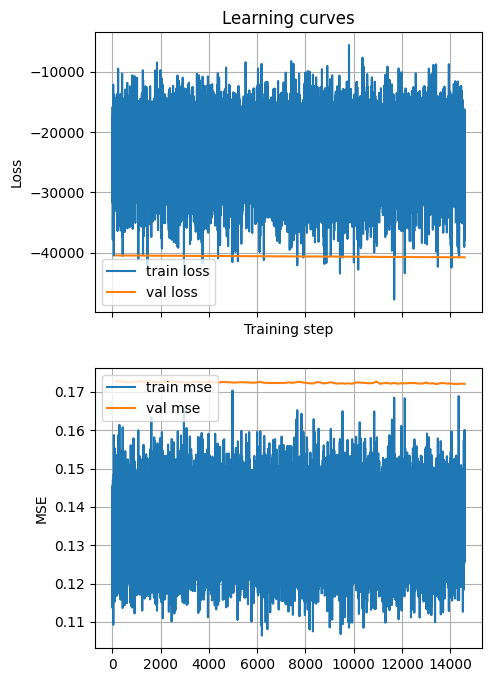

In [77]:
epochs = 100
lr = 1e-6
res = train_ae(
    vae_model,
    epochs=epochs,
    train_loader=train_loader,
    val_loader=val_loader,
    lr=lr,
    loss_fn=loss_fn,
    loss_fn_args=loss_fn_args,
    # clip_value=500000,
)

In [100]:
import torch
from sklearn.metrics import mean_squared_error


def evaluate(model, test_loader):
    model.eval()
    device = next(model.parameters()).device  # Get the device of the model
    mse = 0.0
    with torch.no_grad():
        for inputs, _ in test_loader:
            inputs = inputs.to(device)  # Move inputs to the same device as the model
            reconstructions = model(inputs)
            mse += mean_squared_error(
                inputs.cpu().view(inputs.shape[0], -1),
                reconstructions.cpu().view(reconstructions.shape[0], -1),
            )
    return mse / len(test_loader)

In [101]:
print("Typical test set MSE: ", evaluate(vae_model, test_typical_loader))

Typical test set MSE:  0.13702762286952683


In [102]:
print("Novel test set MSE: ", evaluate(vae_model, test_novel_loader))

Novel test set MSE:  0.13068917795669202


## Visualize reprroduction

In [103]:
def display_reproductions(model, loader, n=8):
    reconstructions = []
    inputs = []
    model.eval()
    device = next(model.parameters()).device  # Get the device of the model

    with torch.no_grad():
        for i, (input, _) in enumerate(loader):
            if i >= n:
                break
            input = input.to(device)  # Move input to the same device as the model
            inputs.append(input.cpu())  # Store the original input on CPU for plotting
            reconstructions.append(
                model(input).cpu()
            )  # Move the output to CPU for plotting

    fig, axes = plt.subplots(2, n, figsize=(20, 5))
    for i in range(n):
        rec = reconstructions[i][0].squeeze(0)
        rec = rec[:3, :, :]
        rec = np.transpose(rec, (1, 2, 0))
        rec = np.take(rec, [2, 0, 1], axis=2)

        img = inputs[i][0].squeeze(0)
        img = img[:3, :, :]
        img = np.transpose(img, (1, 2, 0))
        img = np.take(img, [2, 0, 1], axis=2)

        axes[0, i].imshow(np.interp(img, (img.min(), img.max()), (0, 1)))
        axes[1, i].imshow(np.interp(rec, (rec.min(), rec.max()), (0, 1)))
        axes[0, i].axis("off")
        axes[1, i].axis("off")
    plt.show()

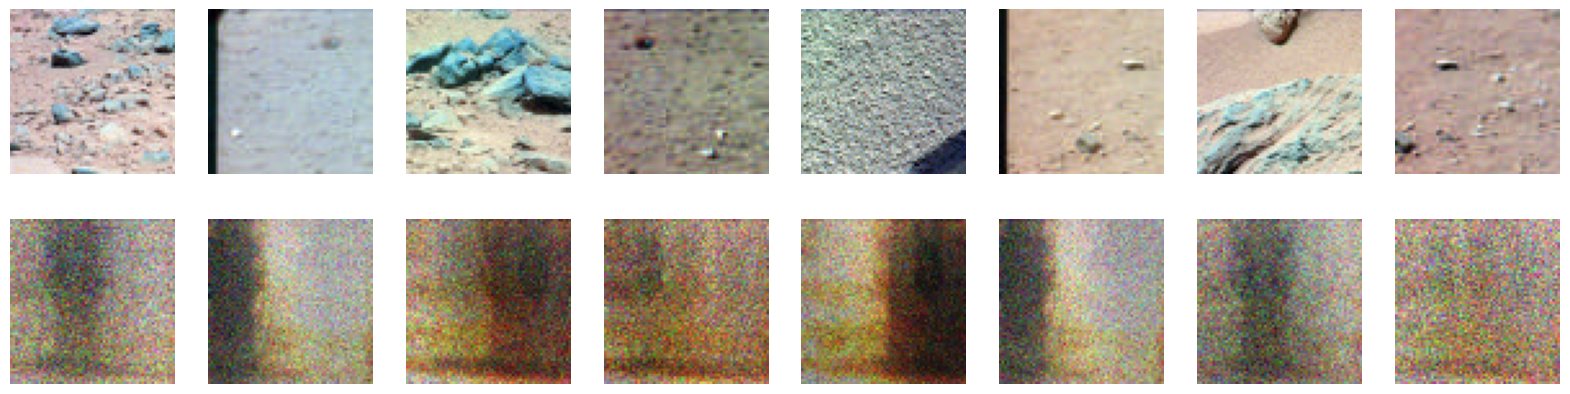

In [132]:
display_reproductions(vae_model, test_typical_loader, n=8)

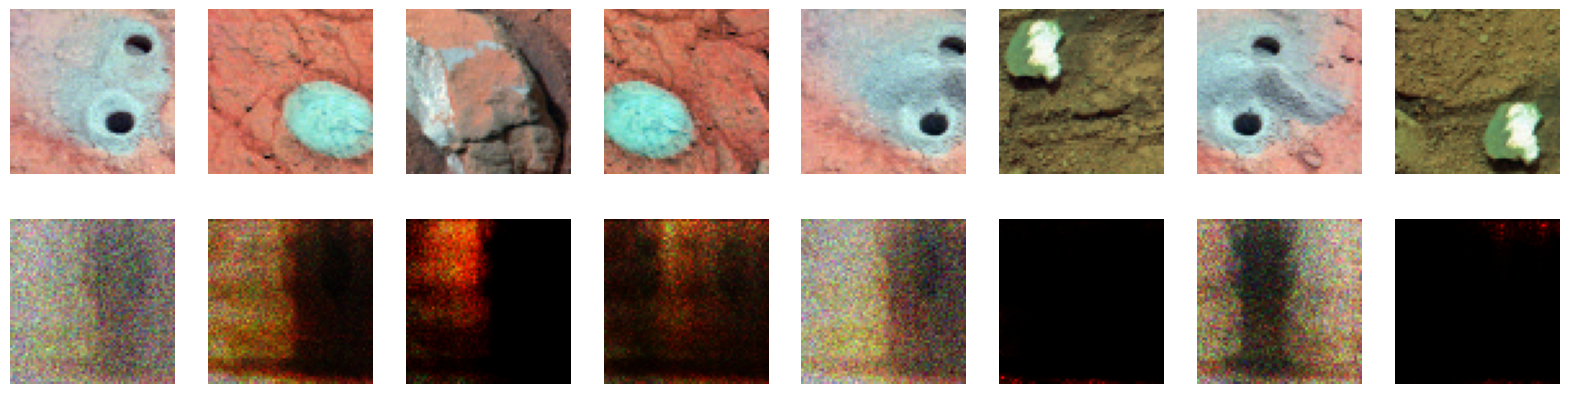

In [105]:
display_reproductions(vae_model, test_novel_loader, n=8)

### Save model

In [133]:
import torch

# save the model
torch.save(vae_model.state_dict(), "vae_model-50-epoch-z-128.pth")

In [142]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


def load_model(
    model_path: str,
    n_data_features: int,
    n_hidden_features: int,
    n_latent_features: int,
):
    vae_model_loaded = VariationalAutoencoder(
        n_data_features=n_data_features,
        n_encoder_hidden_features=n_hidden_features,
        n_decoder_hidden_features=n_hidden_features,
        n_latent_features=n_latent_features,  # how many features will be used to represent input
    )
    vae_model_loaded.load_state_dict(torch.load(model_path, map_location=device))
    return vae_model_loaded


vae_model_loaded = load_model(
    "vae_model-250-epoch.pth",
    n_data_features=64 * 64 * 6,
    n_hidden_features=1024,
    n_latent_features=128,
)
# vae_model_loaded.load_state_dict(torch.load("vae_model-250-epoch.pth"))

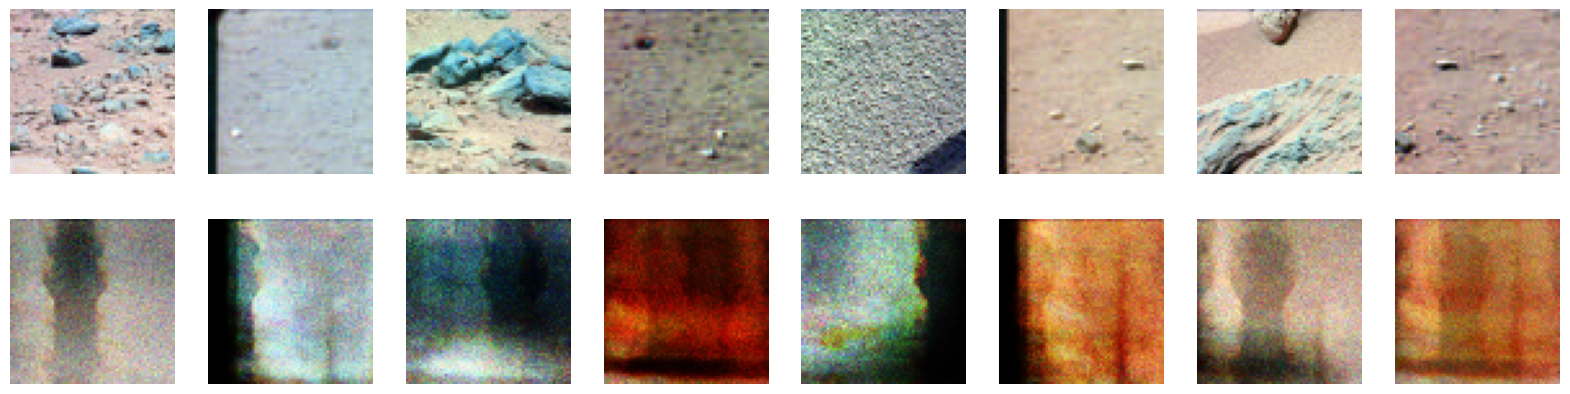

In [143]:
display_reproductions(vae_model_loaded, test_typical_loader, n=8)

## Novelty score

In [144]:
import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader
from sklearn.metrics import pairwise_distances_argmin_min


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


class NoveltyDetection:
    def __init__(self, vae: VariationalAutoencoder, normal_data_loader: DataLoader):
        """
        :param vae: Trained VAE model
        :param normal_data_loader: DataLoader containing normal data samples
        """
        self.vae = vae
        self.normal_data_loader = normal_data_loader

        # Encode normal data to get the mean in latent space
        self.normal_latent_means = self._compute_latent_means(normal_data_loader)

    def _compute_latent_means(self, data_loader: DataLoader):
        """
        Encode the data to get the mean in latent space
        :param data_loader: DataLoader with data to encode
        :return: Tensor of latent space means
        """
        latent_means = []
        self.vae.eval()
        with torch.no_grad():
            for data, _ in data_loader:
                data = data.to(device)

                data = data.view(data.shape[0], -1)
                z_m, _ = self.vae.encoder(data)

                latent_means.append(z_m.cpu())
        return torch.cat(latent_means, dim=0)

    def compute_novelty_score(self, test_data_loader: DataLoader):
        """
        Compute the novelty score for the test data
        :param test_data_loader: DataLoader with test data
        :return: Novelty scores for each test data point
        """
        self.vae.eval()
        novelty_scores = []
        with torch.no_grad():
            for test_data, _ in test_data_loader:
                test_data = test_data.to(device)

                # print(test_data.shape)
                test_data = test_data.view(test_data.shape[0], -1)

                z_m_test, _ = self.vae.encoder(test_data)

                # Compute the Euclidean distance between each test point mean and all normal data means
                distances = torch.cdist(z_m_test, self.normal_latent_means.to(device))

                # Find the minimum distance for each test point
                min_distances, _ = distances.min(dim=1)

                novelty_scores.extend(min_distances.cpu().numpy())

        return novelty_scores

In [146]:
# move the model to the device
vae_model_loaded = vae_model_loaded.to(device)
novelty_detection = NoveltyDetection(vae_model_loaded, train_loader)

typical_novelty_scores = novelty_detection.compute_novelty_score(test_typical_loader)
novel_novelty_scores = novelty_detection.compute_novelty_score(test_novel_loader)

# compare the novelty scores
print("Typical novelty scores:")
print(typical_novelty_scores)
print("Novel novelty scores:")
print(novel_novelty_scores)

Typical novelty scores:
[4.749761, 7.2593207, 9.672688, 4.5952115, 6.0151024, 5.662375, 5.2864237, 3.0585818, 5.243936, 3.592357, 17.383713, 3.2752523, 20.148678, 4.1036243, 4.165673, 2.2658865, 4.944494, 3.474282, 3.5777535, 4.131563, 3.6992512, 5.9414854, 4.1666713, 2.3665853, 5.6250234, 2.8147564, 4.190701, 3.4386027, 3.5127938, 4.357156, 4.271069, 7.1330543, 3.7166326, 5.001392, 4.386828, 6.4031863, 4.496515, 6.3677645, 9.192409, 5.4871073, 12.976658, 4.410395, 3.5046866, 7.585327, 3.006494, 5.6036267, 3.1315362, 6.4543123, 4.4995527, 7.413854, 3.0657127, 5.9524503, 3.584009, 5.852922, 4.3412337, 7.948241, 3.5618734, 6.6846614, 4.0475664, 5.8629, 3.4526217, 7.8658814, 3.6834288, 10.950329, 4.5196595, 9.050876, 4.591576, 11.644865, 2.8437421, 11.8012085, 5.2589273, 13.645438, 6.4061403, 10.140324, 3.5095398, 13.855254, 4.5939617, 16.999975, 5.343544, 4.693568, 2.8220403, 3.436979, 5.9279537, 2.6146884, 14.235643, 5.1529603, 5.7230153, 3.2612538, 3.553755, 3.5382864, 1.0218709, 1.625

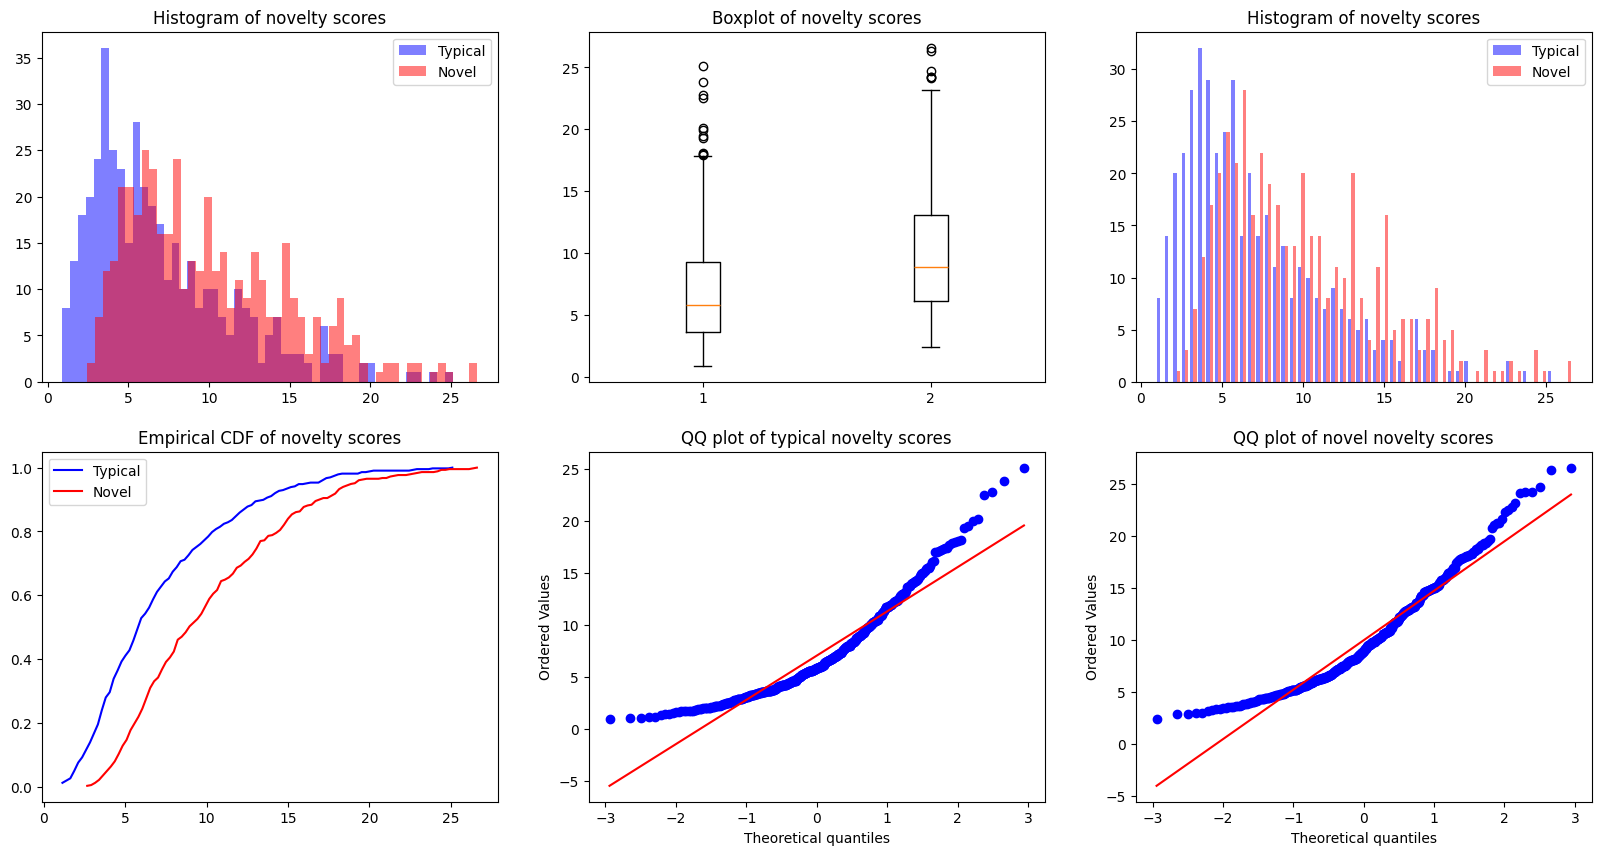

In [147]:
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt

# plot the novelty scores

fig, axes = plt.subplots(2, 3, figsize=(20, 10))

axes[0, 0].hist(
    typical_novelty_scores, bins=50, alpha=0.5, color="blue", label="Typical"
)
axes[0, 0].hist(novel_novelty_scores, bins=50, alpha=0.5, color="red", label="Novel")
axes[0, 0].set_title("Histogram of novelty scores")
axes[0, 0].legend()

axes[0, 1].boxplot([typical_novelty_scores, novel_novelty_scores])
axes[0, 1].set_title("Boxplot of novelty scores")

axes[0, 2].hist(
    [typical_novelty_scores, novel_novelty_scores],
    bins=50,
    alpha=0.5,
    color=["blue", "red"],
    label=["Typical", "Novel"],
)
axes[0, 2].set_title("Histogram of novelty scores")
axes[0, 2].legend()

# Compute the empirical CDFs
n_bins = 100
counts, bin_edges = np.histogram(typical_novelty_scores, bins=n_bins, density=True)
cdf = np.cumsum(counts)
axes[1, 0].plot(bin_edges[1:], cdf / cdf[-1], label="Typical", color="blue")

counts, bin_edges = np.histogram(novel_novelty_scores, bins=n_bins, density=True)
cdf = np.cumsum(counts)
axes[1, 0].plot(bin_edges[1:], cdf / cdf[-1], label="Novel", color="red")
axes[1, 0].set_title("Empirical CDF of novelty scores")
axes[1, 0].legend()

# Compute the QQ plot
stats.probplot(typical_novelty_scores, dist="norm", plot=axes[1, 1])
axes[1, 1].set_title("QQ plot of typical novelty scores")

stats.probplot(novel_novelty_scores, dist="norm", plot=axes[1, 2])
axes[1, 2].set_title("QQ plot of novel novelty scores")

plt.show()

## Different VAE implementation

In [22]:
import os
import numpy as np
import torch
import torch.nn as nn

# import torchvision.transforms as transforms
import pyro
import pyro.distributions as dist
from pyro.infer import SVI, Trace_ELBO
from pyro.optim import Adam

assert pyro.__version__.startswith("1.9.1")
pyro.distributions.enable_validation(False)
pyro.set_rng_seed(0)
# Enable smoke test - run the notebook cells on CI.
smoke_test = "CI" in os.environ

# Define the image dimensions
image_height, image_width, num_channels = 64, 64, 6
n_data_features = image_height * image_width * num_channels


class Decoder(nn.Module):
    def __init__(self, z_dim, hidden_dim, n_data_features: int):
        super().__init__()
        # setup the two linear transformations used
        self.fc1 = nn.Linear(z_dim, hidden_dim)
        self.fc21 = nn.Linear(hidden_dim, n_data_features)
        # setup the non-linearities
        self.softplus = nn.Softplus()
        self.sigmoid = nn.Sigmoid()
        self.n_data_features = n_data_features

    def forward(self, z):
        # define the forward computation on the latent z
        hidden = self.softplus(self.fc1(z))
        loc_img = self.sigmoid(self.fc21(hidden))
        # if torch.isnan(loc_img).any():
        #     print("NaN detected in Decoder output")
        # else:
        #     print("No NaN detected in Decoder output")
        return loc_img


class Encoder(nn.Module):
    def __init__(self, z_dim, hidden_dim, n_data_features: int):
        super().__init__()
        # setup the three linear transformations used
        self.fc1 = nn.Linear(n_data_features, hidden_dim)
        self.fc21 = nn.Linear(hidden_dim, z_dim)
        self.fc22 = nn.Linear(hidden_dim, z_dim)
        # setup the non-linearities
        self.softplus = nn.Softplus()
        self.n_data_features = n_data_features

    def forward(self, x):
        x = x.reshape(-1, self.n_data_features)
        hidden = self.softplus(self.fc1(x))
        z_loc = self.fc21(hidden)
        z_scale = torch.exp(self.fc22(hidden))  # Ensure z_scale is always positive
        # if torch.isnan(z_loc).any() or torch.isnan(z_scale).any():
        #     print("NaN detected in Encoder output")
        # else:
        #     print("No NaN detected in Encoder output")
        return z_loc, z_scale


class VAE(nn.Module):
    n_data_features: int

    def __init__(
        self,
        z_dim=50,
        hidden_dim=400,
        use_cuda=False,
        n_data_features: int = n_data_features,
    ):
        super().__init__()
        # create the encoder and decoder networks
        self.encoder = Encoder(z_dim, hidden_dim, n_data_features)
        self.decoder = Decoder(z_dim, hidden_dim, n_data_features)
        self.n_data_features = n_data_features

        if use_cuda:
            self.cuda()
        self.use_cuda = use_cuda
        self.z_dim = z_dim

    def model(self, x):
        pyro.module("decoder", self.decoder)
        with pyro.plate("data", x.shape[0]):
            z_loc = x.new_zeros(torch.Size((x.shape[0], self.z_dim)))
            z_scale = x.new_ones(torch.Size((x.shape[0], self.z_dim)))
            z = pyro.sample("latent", dist.Normal(z_loc, z_scale).to_event(1))
            loc_img = self.decoder(z)
            pyro.sample(
                "obs",
                dist.Bernoulli(loc_img).to_event(1),
                obs=x.reshape(-1, self.n_data_features),
            )

    def guide(self, x):
        pyro.module("encoder", self.encoder)
        with pyro.plate("data", x.shape[0]):
            z_loc, z_scale = self.encoder(x)
            pyro.sample("latent", dist.Normal(z_loc, z_scale).to_event(1))

    def reconstruct_img(self, x):
        z_loc, z_scale = self.encoder(x)
        z = dist.Normal(z_loc, z_scale).sample()
        loc_img = self.decoder(z)
        if torch.isnan(loc_img).any():
            print("NaN detected in reconstructed image")
        return loc_img

AssertionError: 

In [83]:
import os
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import pyro
import pyro.distributions as dist
from pyro.infer import SVI, Trace_ELBO
from pyro.optim import Adam
from tqdm.auto import tqdm, trange

# assert pyro.__version__.startswith("1.9.1")
pyro.distributions.enable_validation(False)
pyro.set_rng_seed(0)
# Enable smoke test - run the notebook cells on CI.
smoke_test = "CI" in os.environ

# Define the image dimensions
image_height, image_width, num_channels = 64, 64, 6
n_data_features = image_height * image_width * num_channels


class Decoder(nn.Module):
    def __init__(self, z_dim, hidden_dim, n_data_features: int):
        super().__init__()
        # setup the two linear transformations used
        self.fc1 = nn.Linear(z_dim, hidden_dim)
        self.fc21 = nn.Linear(hidden_dim, n_data_features)
        # setup the non-linearities
        self.softplus = nn.Softplus()
        self.sigmoid = nn.Sigmoid()
        self.n_data_features = n_data_features

    def forward(self, z):
        # define the forward computation on the latent z
        hidden = self.softplus(self.fc1(z))
        loc_img = self.sigmoid(self.fc21(hidden))
        return loc_img


class Encoder(nn.Module):
    def __init__(self, z_dim, hidden_dim, n_data_features: int):
        super().__init__()
        # setup the three linear transformations used
        self.fc1 = nn.Linear(n_data_features, hidden_dim)
        self.fc21 = nn.Linear(hidden_dim, z_dim)
        self.fc22 = nn.Linear(hidden_dim, z_dim)
        # setup the non-linearities
        self.softplus = nn.Softplus()
        self.n_data_features = n_data_features

    def forward(self, x):
        x = x.reshape(-1, self.n_data_features)
        hidden = self.softplus(self.fc1(x))
        z_loc = self.fc21(hidden)
        z_scale = torch.exp(self.fc22(hidden))  # Ensure z_scale is always positive
        return z_loc, z_scale


class VAE(nn.Module):
    n_data_features: int

    def __init__(
        self,
        z_dim=50,
        hidden_dim=400,
        use_cuda=False,
        n_data_features: int = n_data_features,
    ):
        super().__init__()
        # create the encoder and decoder networks
        self.encoder = Encoder(z_dim, hidden_dim, n_data_features)
        self.decoder = Decoder(z_dim, hidden_dim, n_data_features)
        self.n_data_features = n_data_features

        if use_cuda:
            self.cuda()
        self.use_cuda = use_cuda
        self.z_dim = z_dim

    def model(self, x):
        pyro.module("decoder", self.decoder)
        with pyro.plate("data", x.shape[0]):
            z_loc = x.new_zeros(torch.Size((x.shape[0], self.z_dim)))
            z_scale = x.new_ones(torch.Size((x.shape[0], self.z_dim)))
            z = pyro.sample("latent", dist.Normal(z_loc, z_scale).to_event(1))
            loc_img = self.decoder(z)
            pyro.sample(
                "obs",
                dist.Bernoulli(loc_img).to_event(1),
                obs=x.reshape(-1, self.n_data_features),
            )

    def guide(self, x):
        pyro.module("encoder", self.encoder)
        with pyro.plate("data", x.shape[0]):
            z_loc, z_scale = self.encoder(x)
            pyro.sample("latent", dist.Normal(z_loc, z_scale).to_event(1))

    def reconstruct_img(self, x):
        z_loc, z_scale = self.encoder(x)
        z = dist.Normal(z_loc, z_scale).sample()
        loc_img = self.decoder(z)
        if torch.isnan(loc_img).any():
            print("NaN detected in reconstructed image")
        return loc_img


def train(svi, train_loader, model: VAE, use_cuda=False, epochs=10):
    train_metrics = {
        "loss": [],
        "step": [],
    }
    global_step = 0

    for epoch in trange(epochs, desc="epoch"):
        model.train()
        pbar = tqdm(train_loader, desc="step", leave=False)
        for x, _ in pbar:
            if use_cuda:
                x = x.cuda()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 5.0)
            step_loss = svi.step(x)
            train_metrics["loss"].append(step_loss / len(x))
            train_metrics["step"].append(global_step)
            global_step += 1
            pbar.set_postfix(loss=step_loss / len(x))
        pbar.close()

    plot_metrics(train_metrics)
    return train_metrics


def evaluate(svi, test_loader, model: VAE, use_cuda=False):
    test_loss = 0.0
    model.eval()
    for x, _ in test_loader:
        if use_cuda:
            x = x.cuda()
        test_loss += svi.evaluate_loss(x)
    normalizer_test = len(test_loader.dataset)
    total_epoch_loss_test = test_loss / normalizer_test
    return total_epoch_loss_test


def plot_metrics(train_metrics):
    fig, ax1 = plt.subplots(1, 1, figsize=(10, 5))
    ax1.plot(train_metrics["step"], train_metrics["loss"], label="train loss")
    ax1.set_xlabel("Training step")
    ax1.set_ylabel("Loss")
    ax1.set_title("Learning curves")
    ax1.grid()
    ax1.legend()
    plt.show()

epoch: 100%|██████████| 50/50 [05:52<00:00,  7.06s/it]


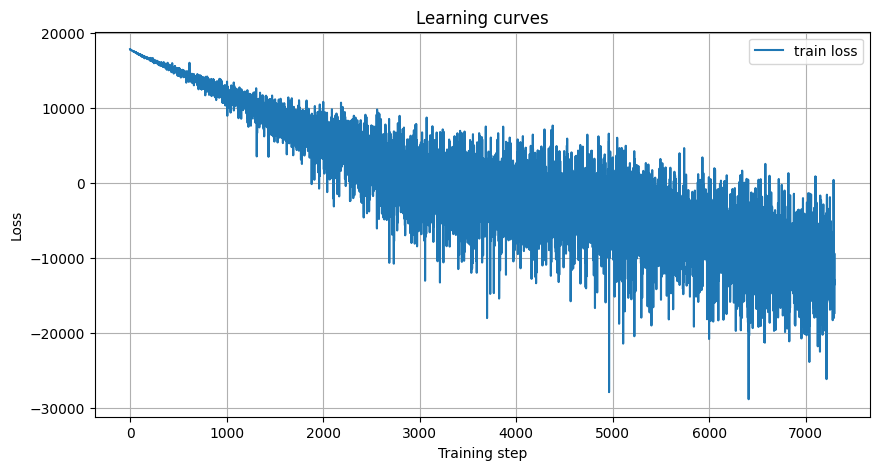

test loss: 973.9887827662794


In [85]:
# Run options
LEARNING_RATE = 1.0e-6
USE_CUDA = True
NUM_EPOCHS = 50
TEST_FREQUENCY = 5
# train_loader, val_loader = setup_data_loaders(batch_size=256, use_cuda=USE_CUDA)

pyro.clear_param_store()

# setup the VAE
vae = VAE(use_cuda=USE_CUDA, n_data_features=64 * 64 * 6, z_dim=128, hidden_dim=1024)

adam_args = {"lr": LEARNING_RATE}
optimizer = Adam(adam_args)

svi = SVI(vae.model, vae.guide, optimizer, loss=Trace_ELBO())

train_metrics = total_epoch_loss_train = train(
    svi, train_loader, vae, use_cuda=USE_CUDA, epochs=NUM_EPOCHS
)

test_typical_loss = evaluate(svi, test_typical_loader, vae, use_cuda=USE_CUDA)
print(f"test loss: {test_typical_loss}")

In [86]:
def display_reproductions_2(model: VAE, loader, n=8):
    reconstructions = []
    inputs = []
    model.eval()
    device = next(model.parameters()).device

    with torch.no_grad():
        for i, (input, _) in enumerate(loader):
            if i >= n:
                break
            input = input.to(device)
            inputs.append(input.cpu())
            reconstructions.append(model.reconstruct_img(input).cpu())

    fig, axes = plt.subplots(2, n, figsize=(20, 5))
    for i in range(n):
        rec = reconstructions[i][0].squeeze(0)
        rec = rec.view(6, 64, 64)
        rec = rec[:3, :, :]
        rec = np.transpose(rec, (1, 2, 0))
        rec = np.take(rec, [2, 0, 1], axis=2)

        img = inputs[i][0].squeeze(0)
        img = img[:3, :, :]
        img = np.transpose(img, (1, 2, 0))
        img = np.take(img, [2, 0, 1], axis=2)

        axes[0, i].imshow(np.interp(img, (img.min(), img.max()), (0, 1)))
        axes[1, i].imshow(np.interp(rec, (rec.min(), rec.max()), (0, 1)))
        axes[0, i].axis("off")
        axes[1, i].axis("off")
    plt.show()

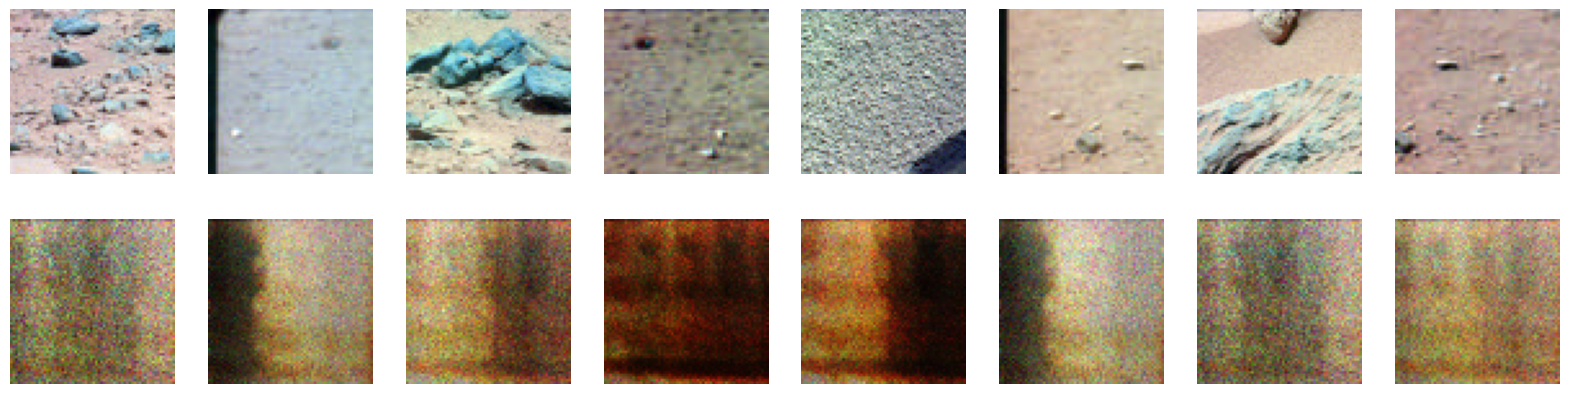

In [87]:
display_reproductions_2(vae, test_typical_loader, n=8)

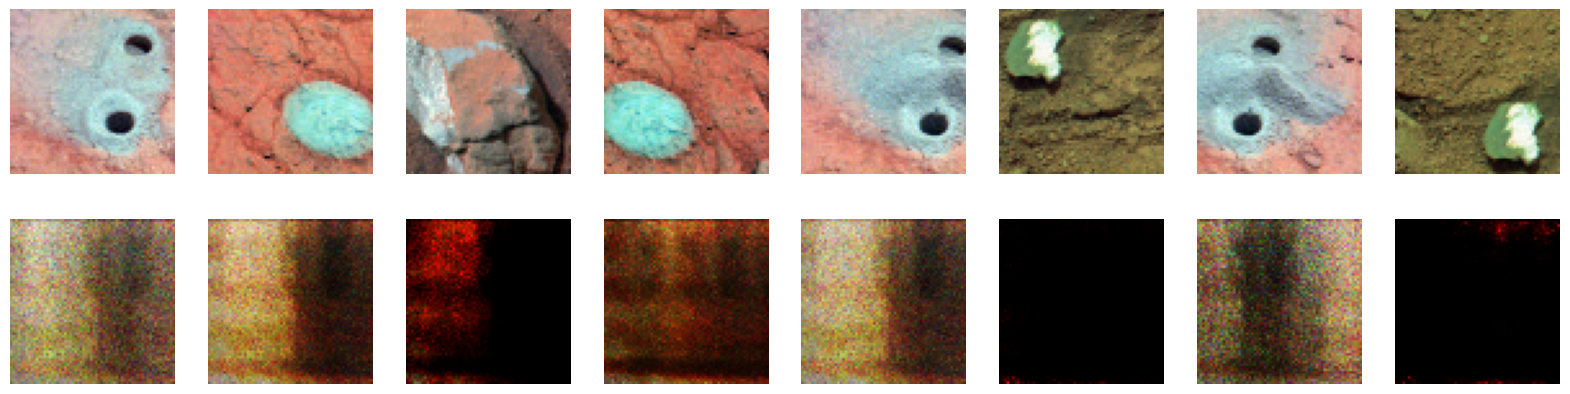

In [88]:
display_reproductions_2(vae, test_novel_loader, n=8)